Illustration of regressor-wise and contrast-wise variance inflation factor (VIF) estimation for fMRI design matrix and corresponding contrasts.  Collinearity is only worrisome when it involves the contrasts of interest in a study.  This illustration of an unlikely go/nogo task shows high VIF on a regressor-by-regressor basis is actually fine since the VIF for the contrasts is well controlled (VIF<5).
Reminder: High VIF is only a concern if studying that specific parameter, as that parameter's estimate is likely to have high variability if the VIF is elevated.  

In [1]:
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def est_vif(desmat):
    '''
    General variance inflation factor estimation.  Calculates VIF for all 
    regressors in the design matrix
    input:
        desmat: design matrix.  Intercept not required.
    output:
      vif_data: Variance inflation factor for each regressor in the design matrix
                generally goal is VIF<5
    '''
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    desmat_with_intercept = desmat.copy()
    desmat_with_intercept['intercept'] = 1
    vif_data = pd.DataFrame()
    vif_data['regressor'] = desmat_with_intercept.columns.drop('intercept')
    vif_data['VIF'] = [variance_inflation_factor(desmat_with_intercept.values, i)
                          for i in range(len(desmat_with_intercept.columns))
                          if desmat_with_intercept.columns[i] != 'intercept']
    return vif_data


def get_eff_reg_vif(desmat, contrast):
    '''
    The goal of this function is to estimate a variance inflation factor for a contrast.
    This is done by extending the effective regressor definition from Smith et al (2007)
    Meaningful design and contrast estimability (NeuroImage).  Regressors involved
    in the contrast estimate are rotated to span the same space as the original space
    consisting of the effective regressor and and an orthogonal basis.  The rest of the 
    regressors are unchanged.
    input:
        desmat: design matrix.  Assumed to be a pandas dataframe with column  
             headings which are used define the contrast of interest
        contrast: a single contrast defined in string format
    output:
        vif: a single VIF for the contrast of interest  
    '''
    from scipy.linalg import null_space
    from nilearn.glm.contrasts import expression_to_contrast_vector
    contrast_def = expression_to_contrast_vector(contrast, desmat.columns)
    des_nuisance_regs = desmat[desmat.columns[contrast_def == 0]]
    des_contrast_regs = desmat[desmat.columns[contrast_def != 0]]

    con = np.atleast_2d(contrast_def[contrast_def != 0])
    con2_t = null_space(con)
    con_t = np.transpose(con)
    x = des_contrast_regs.copy().values
    q = np.linalg.pinv(np.transpose(x)@ x)
    f1 = np.linalg.pinv(con @ q @ con_t)
    pc = con_t @ f1 @ con @ q
    con3_t = con2_t - pc @ con2_t
    f3 = np.linalg.pinv(np.transpose(con3_t) @ q @ con3_t)
    eff_reg = x @ q @ np.transpose(con) @ f1
    eff_reg = pd.DataFrame(eff_reg, columns = [contrast])

    other_reg = x @ q @ con3_t @ f3 
    other_reg_names = [f'orth_proj{val}' for val in range(other_reg.shape[1])]
    other_reg = pd.DataFrame(other_reg, columns = other_reg_names)

    des_for_vif = pd.concat([eff_reg, other_reg, des_nuisance_regs], axis = 1)
    vif_dat = est_vif(des_for_vif)
    vif_dat.rename(columns={'regressor': 'contrast'}, inplace=True)
    vif_output = vif_dat[vif_dat.contrast == contrast]
    return vif_output


def get_all_contrast_vif(desmat, contrasts):
    '''
    Calculates the VIF for multiple contrasts
    input:
        desmat: design matrix.  Pandas data frame, column names must 
                be used in the contrast definitions
        contrasts: A dictionary of contrasts defined in string format
    output:
        vif_contrasts: Data frame containing the VIFs for all contrasts
    '''
    vif_contrasts = {'contrast': [],
                      'VIF': []}
    for key, item in contrasts.items():
        vif_out = get_eff_reg_vif(desmat, item)
        vif_contrasts['contrast'].append(vif_out['contrast'][0])
        vif_contrasts['VIF'].append(vif_out['VIF'][0]) 
    vif_contrasts = pd.DataFrame(vif_contrasts)
    return vif_contrasts     

/Users/jeanettemumford/.pyenv/versions/3.8.5/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
events = pd.DataFrame({'onset': np.linspace(2, 26,10),
          'duration': [1] * 10,
          'trial_type': ['go', 'nogo'] * 5})

In [3]:
nogo_3col = events.loc[((events['trial_type'] == 'nogo')), ['onset', 'duration'] ]
nogo_3col['amplitude'] = 1
go_3col = events.loc[(events['trial_type'] == 'go') , ['onset', 'duration'] ]
go_3col['amplitude'] = 1

In [4]:
go, go_names = compute_regressor(
        np.transpose(np.array(go_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'go'
    ) 
nogo, nogo_names = compute_regressor(
        np.transpose(np.array(nogo_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'nogo'
    ) 
go_pd = pd.DataFrame(go, columns=go_names)
nogo_pd = pd.DataFrame(nogo, columns=nogo_names)

desmat = pd.concat([go_pd, nogo_pd], axis=1)
contrast = {'go - nogo': 'go - nogo',
            'task vs baseline': '.5*go + .5*nogo'}

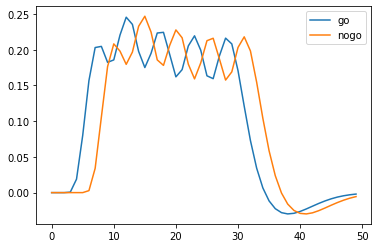

In [5]:
plt.plot(desmat.loc[:,['go', 'nogo']])
plt.legend(['go', 'nogo'])

This might cause unnecessary alarm since the go and nogo VIFs are both > 5.

In [6]:
vif_desmat = est_vif(desmat)
print(vif_desmat)

         regressor        VIF
0               go  10.120215
1    go_derivative   2.655307
2             nogo  10.178187
3  nogo_derivative   2.461170


This shows the contrasts are fine.  So, although individual regressors have high VIF, that's only a concern if one was to study those parameters, alone, the contrasts are fine. 

In [7]:
vif_contrasts = get_all_contrast_vif(desmat, contrast)
print(vif_contrasts)

          contrast       VIF
0        go - nogo  3.226822
1  .5*go + .5*nogo  1.039235
